In [1]:
# @title Imports

import os
import math
import time
import torch
import nbimporter
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from tempfile import TemporaryDirectory
from models._utils import NeuralTransformer
from datasets import load_dataset as load_hf_dataset
from utils import DEVICE, BLOCK_SIZE, NUM_TOKENS, init_random_seeds
from CreateSyntheticDataset import tokenize_and_chunk  # works because of nbimporter

CUDA device found.


## Language modeling with tiny Shakespeare

In [2]:
# @title HuggingFace Tokenizers
# @markdown Note there are two ways to call the tokenizer's encoder.

tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")

expl_text = "Welcome to the 🤗 Tokenizers library."
impl_text = "We are very happy to show you the 🤗 Transformers library."
expl_encode = tokenizer.encode(expl_text)
impl_encode = tokenizer(impl_text)
print(
    f"Calling `tokenizer.encode(text)`:\n\ttext: {expl_text}\n\ttokenized: {expl_encode}\n\tdecoded: {tokenizer.decode(expl_encode)}",
    end="\n\n",
)
print(
    f"Calling `tokenizer(text)`:\n\tobject.keys(): {impl_encode.keys()}\n\ttext: {impl_text}\n\ttokenized: {impl_encode['input_ids']}\n\tdecoded: {tokenizer.decode(impl_encode['input_ids'])}",
    end="\n\n",
)

Calling `tokenizer.encode(text)`:
	text: Welcome to the 🤗 Tokenizers library.
	tokenized: [90, 104, 111, 102, 114, 112, 104, 35, 119, 114, 35, 119, 107, 104, 35, 243, 162, 167, 154, 35, 87, 114, 110, 104, 113, 108, 125, 104, 117, 118, 35, 111, 108, 101, 117, 100, 117, 124, 49, 1]
	decoded: Welcome to the 🤗 Tokenizers library.</s>

Calling `tokenizer(text)`:
	object.keys(): dict_keys(['input_ids', 'attention_mask'])
	text: We are very happy to show you the 🤗 Transformers library.
	tokenized: [90, 104, 35, 100, 117, 104, 35, 121, 104, 117, 124, 35, 107, 100, 115, 115, 124, 35, 119, 114, 35, 118, 107, 114, 122, 35, 124, 114, 120, 35, 119, 107, 104, 35, 243, 162, 167, 154, 35, 87, 117, 100, 113, 118, 105, 114, 117, 112, 104, 117, 118, 35, 111, 108, 101, 117, 100, 117, 124, 49, 1]
	decoded: We are very happy to show you the 🤗 Transformers library.</s>



In [3]:
# @title HuggingFace Datasets

text_dataset = load_hf_dataset("tiny_shakespeare")
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "train:",
    type(text_dataset["train"]["text"]),
    len(text_dataset["train"]["text"]),
    type(text_dataset["train"]["text"][0]),
    len(text_dataset["train"]["text"][0]),
    end="\n\n",
)
print(
    "validation:",
    type(text_dataset["validation"]["text"]),
    len(text_dataset["validation"]["text"]),
    type(text_dataset["validation"]["text"][0]),
    len(text_dataset["validation"]["text"][0]),
    end="\n\n",
)
print(
    "test:",
    type(text_dataset["test"]["text"]),
    len(text_dataset["test"]["text"]),
    type(text_dataset["test"]["text"][0]),
    len(text_dataset["test"]["text"][0]),
    end="\n\n",
)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train: <class 'list'> 1 <class 'str'> 1003854

validation: <class 'list'> 1 <class 'str'> 55770

test: <class 'list'> 1 <class 'str'> 55770



In [4]:
# @title Tokenization and Chunking
# @markdown Apply the tokenization and chunking to each split.

text_dataset = text_dataset.map(
    tokenize_and_chunk, batched=True, fn_kwargs=dict(tokenizer=tokenizer)
)
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "text_dataset['train']['input_ids']:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"][0]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0][0]),
    "\n\tvalue:",
    text_dataset["train"]["input_ids"][0][0],
    end="\n\n",
)
print("~~~" * 50, end="\n\n")

print(f"Original sequence (text):\n\t{text_dataset['train']['text'][0]}", end="\n\n")
print(
    f"Encoded sequence (tokens):\n\t {text_dataset['train']['input_ids'][0]}",
    end="\n\n",
)
print(
    f"Decoded sequence (tokens):\n\t {tokenizer.decode(text_dataset['train']['input_ids'][0])}",
    end="\n\n",
)

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1963
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
})

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

text_dataset['train']['input_ids']:
 	type: <class 'list'> 
	length: 1963

text_dataset['train']['input_ids'][0]:
 	type: <class 'list'> 
	length: 506

text_dataset['train']['input_ids'][0][0]:
 	type: <class 'int'> 
	value: 73

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Original sequence (text):
	First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citi

In [5]:
# @title Define the Transformer model


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)  # batch_first=True
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerModel(torch.nn.Module):
    def __init__(
        self,
        ntoken: int,
        d_model: int,
        nhead: int,
        d_hid: int,
        nlayers: int,
        dropout: float = 0.5,
    ):
        super().__init__()
        self.model_type = "Transformer"
        self.d_model = d_model
        self.embedding = torch.nn.Embedding(ntoken, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(
            d_model, nhead, d_hid, dropout, batch_first=True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.linear = torch.nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [batch_size, seq_len, ntoken]
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = torch.nn.Transformer.generate_square_subsequent_mask(
                src.size(1)  # Use src.size(1) to get the seq_len
            ).to(
                src.device
            )  # Use src.device to match device of src
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

    @torch.no_grad()
    def generate(
        self,
        idx: torch.LongTensor,
        max_new_tokens: int,
        temperature=1.0,
        top_k=None,
    ):
        """
        Special generate method for the Transformer model.
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Since we trained the model to directly predict the next token we take the index as the argmin
        over the distance between the output and the embedding table.
        """
        # Set model to evaluation mode
        self.eval()

        # Loop through time
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= BLOCK_SIZE else idx[:, -BLOCK_SIZE:]
            # forward the model to get the output
            outputs = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = outputs[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1).view(1, 1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [6]:
# @title Create token datasets

train_dataset = [torch.LongTensor(sequence) for sequence in text_dataset["train"]["input_ids"]]
validation_dataset = [
    torch.LongTensor(sequence) for sequence in text_dataset["validation"]["input_ids"]
]
test_dataset = [torch.LongTensor(sequence) for sequence in text_dataset["test"]["input_ids"]]

# get a test sample for an example
data = test_dataset[0].unsqueeze(0)
print("data: ", data.shape, data.dtype, data.requires_grad, data.device, end="\n\n")

data:  torch.Size([1, 511]) torch.int64 False cpu



In [7]:
# @title Instantiate a TransformerModel

ntokens = tokenizer.vocab_size
emsize = 302  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention (NOTE: nhead must be a divisor of d_hid)
dropout = 0.1  # dropout probability

model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(DEVICE)
print(f"Vocab size (i.e. num tokens) = {ntokens}")
print(f"Number of attn heads = {nhead}\n")

Vocab size (i.e. num tokens) = 256
Number of attn heads = 2



In [8]:
# @title Train the Transformer model


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 300
    start_time = time.time()
    global epoch, optimizer, scheduler, criterion

    num_batches = len(train_dataset)
    for batch in range(num_batches):
        tokens = train_dataset[batch].unsqueeze(0)
        # parse into input and target
        input = tokens[:, :-1].to(DEVICE)  # ``[batch_size=1, seq_len]``
        target = tokens[:, 1:].reshape(-1).to(DEVICE)  # ``[batch_size=1 * seq_len]``
        # forward pass
        output = model(input)  # ``[batch_size=1, seq_len, ntokens]``
        output_flat = output.view(-1, ntokens)  # ``[batch_size=1 * seq_len, ntokens]``
        # backpropagation step
        optimizer.zero_grad()
        loss = criterion(output_flat, target)
        # check if the computed loss requires gradient
        if loss.requires_grad:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(validation_dataset)
        for batch in range(num_batches):
            tokens = validation_dataset[batch].unsqueeze(0)
            input = tokens[:, :-1].to(DEVICE)
            target = tokens[:, 1:].reshape(-1).to(DEVICE)
            output = model(input)
            output_flat = output.view(-1, ntokens)
            total_loss += criterion(output_flat, target).item()
    return total_loss / num_batches

In [9]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

criterion = torch.nn.CrossEntropyLoss()  # loss function
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

best_val_loss = float("inf")
epochs = 0

# Load the previously saved best model checkpoint if it exists
final_model_params_path = os.path.join("../models/", "shakespeare_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...\n")
    model.load_state_dict(torch.load(final_model_params_path))
    best_val_loss = evaluate(model)
    print(f"Previous validation loss: \t {best_val_loss:5.2f}\n")

# Train the model
if epochs > 0:
    print(f"Training for {epochs} epoch(s)...\n")
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train(model)
            print(f"TRAIN done.\n")
            val_loss = evaluate(model)
            print(f"EVAL done.\n")
            val_ppl = math.exp(val_loss)
            elapsed = time.time() - epoch_start_time
            print("-" * 89)
            print(
                f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
                f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
            )
            print("-" * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"Saving the newest best model...\n")
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step()

        if os.path.exists(best_model_params_path):
            print(f"Reloading the overall best model...\n")
            model.load_state_dict(torch.load(best_model_params_path))  # reload the final best model
            print(f"Saving the overall best model to permanent location...\n")
            torch.save(
                model.state_dict(),
                final_model_params_path,
            )  # save the final best model

In [10]:
# @title Generate new text

max_new_tokens = 100
idx = test_dataset[0][:-1].unsqueeze(0).to(DEVICE)
idx_gen = model.generate(idx, max_new_tokens, top_k=None)

print(idx.shape, idx_gen.shape, end="\n\n")
print(tokenizer.decode(idx.tolist()[0]), end="\n\n")
print(tokenizer.decode(idx_gen.tolist()[0][-max_new_tokens:]), end="\n\n")

torch.Size([1, 510]) torch.Size([1, 610])

rance ta'en As shall with either part's agreement stand? BAPTISTA: Not in my house, Lucentio; for, you know, Pitchers have ears, and I have many servants: Besides, old Gremio is hearkening still; And happily we might be interrupted. TRANIO: Then at my lodging, an it like you: There doth my father lie; and there, this night, We'll pass the business privately and well. Send for your daughter by your servant here: My boy shall fetch the scrivener presently. The worst is this, that, at so slender warning, You

i-4̎|0ښ_.Q>w* 8`ޞ=GŊu-2},/	̲xꇀYP,R<unk>ˍ63v_weH^K#i



## Neural data modeling

In [11]:
# @title Create neural datasets
# @markdown A synthetic dataset where the neural activity is the embeddings of tokens from tiny Shakespeare.

init_random_seeds()  # set random seeds

ntokens = tokenizer.vocab_size
emsize = 302
d_hid = 512
embedding = torch.nn.Embedding(ntokens, emsize, _freeze=True)  # fixed embedding map

# Create datasets
train_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["train"]["input_ids"]
]
validation_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["validation"]["input_ids"]
]
test_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["test"]["input_ids"]
]

# get a test sample for an example
data = test_dataset[0].unsqueeze(0)
print("data: ", data.shape, data.dtype, data.requires_grad, data.device, end="\n\n")

mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
print("mask:", mask.shape, mask.dtype, mask.requires_grad, mask.device, end="\n\n")

data:  torch.Size([1, 511, 302]) torch.float32 False cpu

mask: torch.Size([1, 302]) torch.bool False cpu



In [12]:
# DEBUG

# What tokens and their corresponding characters are in the training set
real_train_tokens = set()
for sequence in text_dataset["train"]["input_ids"]:
    tokens = set(sequence[:-1])
    real_train_tokens.update(tokens)
print(len(real_train_tokens), "\t", real_train_tokens)
print("\t", tokenizer.decode(list(real_train_tokens)))
print("\n", "~" * 333, "\n")

64 	 {35, 36, 39, 41, 42, 47, 48, 49, 54, 61, 62, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125}
	 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [13]:
# @title Instantiate a NeuralTransformer model

model = NeuralTransformer(
    input_size=emsize,
    hidden_size=d_hid,
    version_2=True,
    num_tokens=ntokens,
    # num_tokens=NUM_TOKENS,
    # vq_vae=True,
    vq_vae=False,
).to(DEVICE)
# NOTE: In reality we don't actually know the underlying vocabulary size (i.e. num_tokens) of the embedding table used to generated the neural data.

print(f"Vocab size (i.e. num tokens) = {ntokens}")
print(f"Model internal tokens = {model.num_tokens}")
print(f"Number of attn heads = {model.num_heads}\n")

Vocab size (i.e. num tokens) = 256
Model internal tokens = 256
Number of attn heads = 4



In [14]:
# @title Test NeuralTransformer model's input-output functionality

mask = mask.to(DEVICE)
input = data[:, :-1, :].to(DEVICE)
target = data[:, 1:, :].to(DEVICE)
with torch.no_grad():
    output = model(input, mask)


print(
    "input:",
    input.shape,
    input.dtype,
    input.requires_grad,
    input.device,
    end="\n\n",
)
print(
    "target:",
    target.shape,
    target.dtype,
    target.requires_grad,
    target.device,
    end="\n\n",
)
print(
    "output:",
    output.shape,
    output.dtype,
    output.requires_grad,
    output.device,
    end="\n\n",
)

input: torch.Size([1, 510, 302]) torch.float32 False cuda:0

target: torch.Size([1, 510, 302]) torch.float32 False cuda:0

output: torch.Size([1, 510, 256]) torch.float16 False cuda:0



In [15]:
# @title Test NeuralTransformer model's internal tokenizer

# The code below should only work when we cheat and set the codebook to be exactky the embedding table that was used to generate the neural data.
# This is because the codebook is initialized randomly. If the model has not been trained then there is no reason for its internal tokenizer to
# correctly invert the ground-truth embedding, which should be unknown to us. Thereforem the goal of our optimization is ultimately to learn the
# a codebook that is as close as possible to the ground-truth but unknown embedding map.

if embedding.weight.shape == model.codebook.shape:
    assert not torch.allclose(
        embedding.weight, model.codebook.cpu()
    ), "The codebook should be different from the embedding map!"

# Replace model codebook with the embedding map use to generate the dataset
tmp = model.codebook  # save for later restoration
model.codebook = torch.nn.Parameter(embedding.weight.to(DEVICE))  # let's cheat

assert torch.allclose(
    embedding.weight, model.codebook.cpu()
), "The codebook should be the same as the embedding map!"

# Get some ground-truth test data
token_list = text_dataset["test"]["input_ids"][0]
token_target = torch.LongTensor(token_list)
neural_target = torch.vstack([embedding(t) for t in token_target])

# Compare the tokenized and retokenized sequences when the codebook is the true embedding map
with torch.no_grad():  # model tokenizer takes in a neural sequence and outputs a token sequence
    retokenized_target = model.tokenize_neural_data(neural_target.unsqueeze(0)).squeeze(0)
print(type(token_list), neural_target.shape, token_target.shape, retokenized_target.shape)
print("\t", token_target[:5], retokenized_target[:5], end="\n\n")

# The tokenized and retokenized sequences should be the same
assert torch.allclose(
    token_target, retokenized_target
), "The tokenized and retokenized sequences should be the same!"

# Restore the model codebook to its original random initialization
model.codebook = tmp

if embedding.weight.shape == model.codebook.shape:
    assert not torch.allclose(embedding.weight, model.codebook.cpu())

# Compare the tokenized and retokenized sequences when the codebook is NOT the true embedding map
with torch.no_grad():  # model tokenizer takes in a neural sequence and outputs a token sequence
    retokenized_target = model.tokenize_neural_data(neural_target.unsqueeze(0)).squeeze(0)
print(type(token_list), neural_target.shape, token_target.shape, retokenized_target.shape)
print("\t", token_target[:5], retokenized_target[:5], end="\n\n")

# The tokenized and retokenized sequences should NOT be the same
assert not torch.allclose(
    token_target, retokenized_target
), "The tokenized and retokenized sequences should NOT be the same!"

<class 'list'> torch.Size([511, 302]) torch.Size([511]) torch.Size([511])
	 tensor([117, 100, 113, 102, 104]) tensor([117, 100, 113, 102, 104])

<class 'list'> torch.Size([511, 302]) torch.Size([511]) torch.Size([511])
	 tensor([117, 100, 113, 102, 104]) tensor([168, 137, 114, 110,  39])



In [16]:
# @title Train the NeuralTransformer model


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 300
    start_time = time.time()
    global epoch, optimizer, scheduler

    num_batches = len(train_dataset)
    for batch in range(num_batches):
        data = train_dataset[batch].unsqueeze(0)
        mask = mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
        # parse into input and target
        mask = mask.to(DEVICE)
        input = data[:, :-1, :].to(DEVICE)
        target = data[:, 1:, :].to(DEVICE)
        # forward pass
        output = model(input, mask)  # ``[batch_size=1, seq_len, ntokens]``
        # backpropagation step
        optimizer.zero_grad()
        loss = model.loss_fn()(
            output, target, mask
        )  # flattens output to ``[batch_size=1 * seq_len, ntokens]``

        # check if the computed loss requires gradient
        if loss.requires_grad:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            try:
                ppl = math.exp(cur_loss)
            except OverflowError:
                ppl = float("inf")
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(validation_dataset)
        for batch in range(num_batches):
            data = validation_dataset[batch].unsqueeze(0)
            mask = mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
            mask = mask.to(DEVICE)
            input = data[:, :-1, :].to(DEVICE)
            target = data[:, 1:, :].to(DEVICE)
            output = model(input, mask)
            loss = model.loss_fn()(output, target, mask)
            total_loss += loss.item()

    return total_loss / num_batches

In [17]:
# DEBUG

print(len(model.token_neural_map.unique(dim=0)) - 1, end="\n\n")
print("codebook trainable?", model.codebook.requires_grad, end="\n\n")
print("codebook trained?", model.codebook.grad is not None, end="\n\n")

255

codebook trainable? True

codebook trained? False



(256, 302) (256, 302) (256, 302)


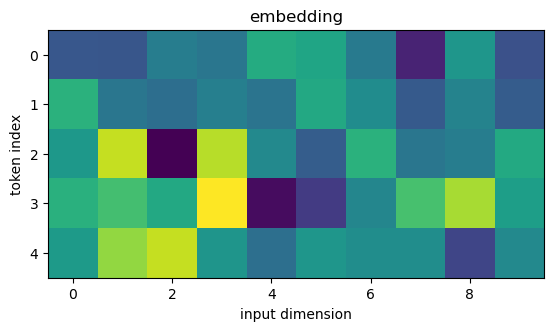

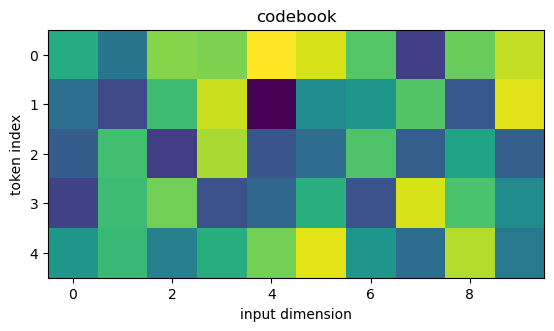

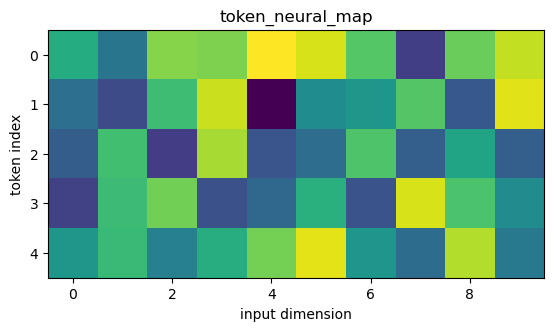

In [18]:
# DEBUG

A = embedding.weight.numpy()
B = model.codebook.detach().cpu().numpy()
C = model.token_neural_map.detach().cpu().numpy()

print(A.shape, B.shape, C.shape)

plt.imshow(A @ A.T)
plt.imshow(A.T @ A)
plt.imshow(A[:5, :10])
plt.title("embedding")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

plt.imshow(B @ B.T)
plt.imshow(B.T @ B)
plt.imshow(B[:5, :10])
plt.title("codebook")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

plt.imshow(C @ C.T)
plt.imshow(C.T @ C)
plt.imshow(C[:5, :10])
plt.title("token_neural_map")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

In [19]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

best_val_loss = float("inf")
epochs = 2

# Load the previously saved best model checkpoint if it exists
final_model_params_path = os.path.join("../models/", "neural_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...\n")
    model.load_state_dict(torch.load(final_model_params_path))
    best_val_loss = evaluate(model)
    print(f"Previous validation loss: \t {best_val_loss:5.2f}\n")

# Train the model
if epochs > 0:
    print(f"Training for {epochs} epoch(s)...\n")
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train(model)
            print(f"TRAIN done.\n")
            val_loss = evaluate(model)
            print(f"EVAL done.\n")
            try:
                val_ppl = math.exp(val_loss)
            except OverflowError:
                val_ppl = float("inf")
            elapsed = time.time() - epoch_start_time
            print("-" * 89)
            print(
                f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
                f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
            )
            print("-" * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"Saving the newest best model...\n")
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step()

        if os.path.exists(best_model_params_path):
            print(f"Reloading the overall best model...\n")
            model.load_state_dict(torch.load(best_model_params_path))  # reload the final best model
            print(f"Saving the overall best model to permanent location...\n")
            torch.save(
                model.state_dict(),
                final_model_params_path,
            )  # save the final best model

Training for 2 epoch(s)...



| epoch   1 |   300/ 1963 batches | lr 5.00 | ms/batch  6.96 | loss 81.99 | ppl 403661779495106578900846422377103360.00
| epoch   1 |   600/ 1963 batches | lr 5.00 | ms/batch  6.76 | loss 26.40 | ppl 291280361921.38
| epoch   1 |   900/ 1963 batches | lr 5.00 | ms/batch  6.76 | loss 17.61 | ppl 44598158.42
| epoch   1 |  1200/ 1963 batches | lr 5.00 | ms/batch  6.78 | loss 13.77 | ppl 953545.77
| epoch   1 |  1500/ 1963 batches | lr 5.00 | ms/batch  6.77 | loss 11.99 | ppl 161728.11
| epoch   1 |  1800/ 1963 batches | lr 5.00 | ms/batch  6.76 | loss  9.74 | ppl 16961.66
TRAIN done.

EVAL done.

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 13.67s | valid loss  9.32 | valid ppl 11135.70
-----------------------------------------------------------------------------------------
Saving the newest best model...

| epoch   2 |   300/ 1963 batches | lr 4.95 | ms/batch  6.72 | loss  8.73 | ppl  6182.91
| epoch   2 |   600/ 1

In [21]:
# DEBUG

print(len(model.token_neural_map.unique(dim=0)) - 1, end="\n\n")
print("codebook trainable?", model.codebook.requires_grad, end="\n\n")
print("codebook trained?", model.codebook.grad is not None, end="\n\n")

255

codebook trainable? True

codebook trained? False



(256, 302) (256, 302) (256, 302)


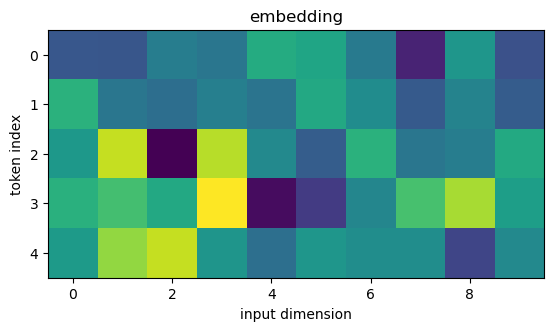

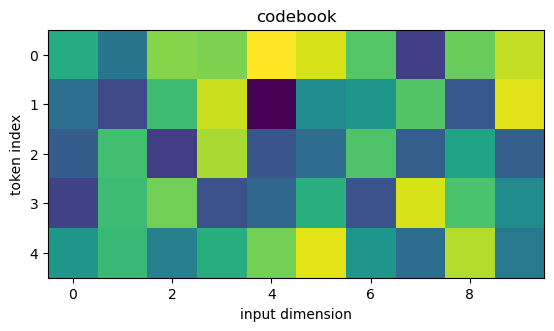

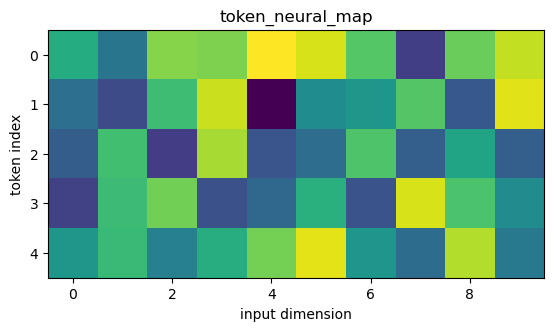

In [22]:
# DEBUG

A = embedding.weight.numpy()
B = model.codebook.detach().cpu().numpy()
C = model.token_neural_map.detach().cpu().numpy()

print(A.shape, B.shape, C.shape)

plt.imshow(A.T @ A)  # (input_size, input_size)
plt.imshow(A[:5, :10])
plt.title("embedding")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

plt.imshow(B.T @ B)  # (input_size, input_size)
plt.imshow(B[:5, :10])
plt.title("codebook")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

plt.imshow(C.T @ C)  # (input_size, input_size)
plt.imshow(C[:5, :10])
plt.title("token_neural_map")
plt.ylabel("token index")
plt.xlabel("input dimension")
plt.show()

In [23]:
# @title Generate new data

data = test_dataset[0][:-1, :].unsqueeze(0).to(DEVICE)
mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0).to(DEVICE)
max_new_tokens = 100
data_gen = model.generate(data, mask, max_new_tokens, autoregressive=True, top_k=None)
print(mask.shape, data.shape, data_gen.shape, embedding.weight.shape, end="\n\n")

torch.Size([1, 302]) torch.Size([1, 510, 302]) torch.Size([1, 100, 302]) torch.Size([256, 302])



In [24]:
# @markdown We want to tokenize the neural data.
# An oracle told us that the neural data itself is an embedding of tokens from some unknown vocabulary.
# We can do this by using the tokenize_neural_data method of our model.

# First run a test on data for which we know what the true token output should be.
# This is just to confirm if our tokenize_neural_data method is working as expected.
with torch.no_grad():
    sequence = data
    inp_tokens = model.tokenize_neural_data(
        neural_sequence=data,
        feature_mask=mask,
        token_matrix=embedding.weight,
    )
    # iff correct these two should match
    print(text_dataset["test"]["input_ids"][0], end="\n\n")  # ground-truth tokens
    print(text_dataset["test"]["text"][0], end="\n\n")  # ground-truth text
    print(inp_tokens.squeeze().tolist(), end="\n\n")  # decoded tokens
    print(tokenizer.decode(inp_tokens.squeeze().tolist()), end="\n\n")  # decoded text

[117, 100, 113, 102, 104, 35, 119, 100, 42, 104, 113, 35, 68, 118, 35, 118, 107, 100, 111, 111, 35, 122, 108, 119, 107, 35, 104, 108, 119, 107, 104, 117, 35, 115, 100, 117, 119, 42, 118, 35, 100, 106, 117, 104, 104, 112, 104, 113, 119, 35, 118, 119, 100, 113, 103, 66, 35, 69, 68, 83, 87, 76, 86, 87, 68, 61, 35, 81, 114, 119, 35, 108, 113, 35, 112, 124, 35, 107, 114, 120, 118, 104, 47, 35, 79, 120, 102, 104, 113, 119, 108, 114, 62, 35, 105, 114, 117, 47, 35, 124, 114, 120, 35, 110, 113, 114, 122, 47, 35, 83, 108, 119, 102, 107, 104, 117, 118, 35, 107, 100, 121, 104, 35, 104, 100, 117, 118, 47, 35, 100, 113, 103, 35, 76, 35, 107, 100, 121, 104, 35, 112, 100, 113, 124, 35, 118, 104, 117, 121, 100, 113, 119, 118, 61, 35, 69, 104, 118, 108, 103, 104, 118, 47, 35, 114, 111, 103, 35, 74, 117, 104, 112, 108, 114, 35, 108, 118, 35, 107, 104, 100, 117, 110, 104, 113, 108, 113, 106, 35, 118, 119, 108, 111, 111, 62, 35, 68, 113, 103, 35, 107, 100, 115, 115, 108, 111, 124, 35, 122, 104, 35, 112, 10

In [25]:
# Now do the same thing on the newly generated data
with torch.no_grad():
    sequence = data_gen
    gen_tokens = model.tokenize_neural_data(
        neural_sequence=sequence,
        feature_mask=mask,
        token_matrix=embedding.weight,
    )
    print(gen_tokens.squeeze().tolist(), end="\n\n")  # decoded tokens
    print(tokenizer.decode(gen_tokens.squeeze().tolist()), end="\n\n")  # decoded text

[117, 104, 100, 113, 104, 100, 113, 35, 100, 121, 104, 100, 111, 111, 103, 35, 100, 113, 103, 35, 100, 113, 114, 35, 100, 113, 35, 100, 113, 104, 100, 113, 104, 100, 113, 103, 35, 100, 113, 103, 35, 100, 156, 76, 35, 100, 113, 104, 100, 111, 111, 35, 100, 113, 106, 104, 100, 111, 111, 111, 104, 100, 118, 102, 100, 113, 35, 100, 117, 35, 100, 113, 35, 100, 111, 111, 111, 111, 111, 35, 100, 100, 113, 104, 100, 113, 35, 100, 72, 81, 68, 61, 35, 100, 33, 118, 35, 100, 90, 35]

reanean avealld and ano an aneaneand and aI aneall angeallleascan ar an alllll aanean aENA: as aW 



In [26]:
# DEBUG

# Assert should not be raised if the model learned to correctly map the tokens in the training  set
for idx in range(data_gen.shape[1]):
    neural = data_gen[:, [idx], :]
    print("sequence time index:", idx, "\nneural:", neural.squeeze()[:5], end="\n\n")

    ct = model.tokenize_neural_data(neural).item()
    coded = model.codebook[torch.tensor(ct, dtype=torch.long)].detach()
    mapped = model.token_neural_map[torch.tensor(ct, dtype=torch.long)]
    print("codebook token index:", ct, "\ncoded:", coded[:5], "\nmapped:", mapped[:5], end="\n\n")

    assert torch.allclose(neural, mapped), "Basic check failed; Inconsistency in mapping!"

    et = model.tokenize_neural_data(neural, token_matrix=embedding.weight).item()
    embedded = embedding(torch.tensor(et, dtype=torch.long))
    print(
        "embedding token index:",
        et,
        "\ncharacter:",
        tokenizer.decode([et]),
        "\nin train set:",
        et in real_train_tokens,
        "\nembedded:",
        embedded[:5],
        end="\n\n",
    )

    if et in real_train_tokens:
        ## DEBUG ###
        assert torch.any(neural != 0), "Model did not learn to map a vector it was trained on!"
        assert torch.allclose(
            embedded, mapped.cpu()
        ), "The learned mapping did not converge to the true embedding!"
        ## DEBUG ###

    print("~" * 99, end="\n\n")

sequence time index: 0 
neural: tensor([ 0.0191,  0.3506, -0.1098,  0.8953, -0.0308], device='cuda:0')

codebook token index: 168 
coded: tensor([-1.3470, -0.0306, -1.2122, -0.3144,  0.3208], device='cuda:0') 
mapped: tensor([ 0.0191,  0.3506, -0.1098,  0.8953, -0.0308], device='cuda:0')

embedding token index: 117 
character: r 
in train set: True 
embedded: tensor([ 0.0191,  0.3506, -0.1098,  0.8953, -0.0308])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sequence time index: 1 
neural: tensor([ 0.5035, -0.1663, -1.0763, -1.5188,  0.0799], device='cuda:0')

codebook token index: 39 
coded: tensor([ 0.1643,  1.4150,  0.3183, -1.0346, -0.7888], device='cuda:0') 
mapped: tensor([ 0.5035, -0.1663, -1.0763, -1.5188,  0.0799], device='cuda:0')

embedding token index: 104 
character: e 
in train set: True 
embedded: tensor([ 0.5034, -0.1664, -1.0771, -1.5196,  0.0803])



AssertionError: The learned mapping did not converge to the true embedding!

In [ ]:
# DEBUG

all_unique_vectors = torch.vstack(train_dataset).unique(dim=0)
learned_unique_vectors = model.token_neural_map.unique(dim=0)
print(all_unique_vectors.shape, learned_unique_vectors.shape)
print()

all_unique_vectors = {tuple(row.round(decimals=2).cpu().numpy()) for row in all_unique_vectors}
learned_unique_vectors = {
    tuple(row.round(decimals=2).cpu().numpy()) for row in learned_unique_vectors
}
print(len(all_unique_vectors), len(learned_unique_vectors))
print()

inter = all_unique_vectors.intersection(learned_unique_vectors)
diff = all_unique_vectors - learned_unique_vectors
print(len(inter), len(diff))
print()